DoD min/max before cleaning: -25469.623 6.4554443

📉 Erosion Volume (m³): -438.14
📈 Deposition Volume (m³): 330.93
🔁 Net Volume Change (m³): -107.21


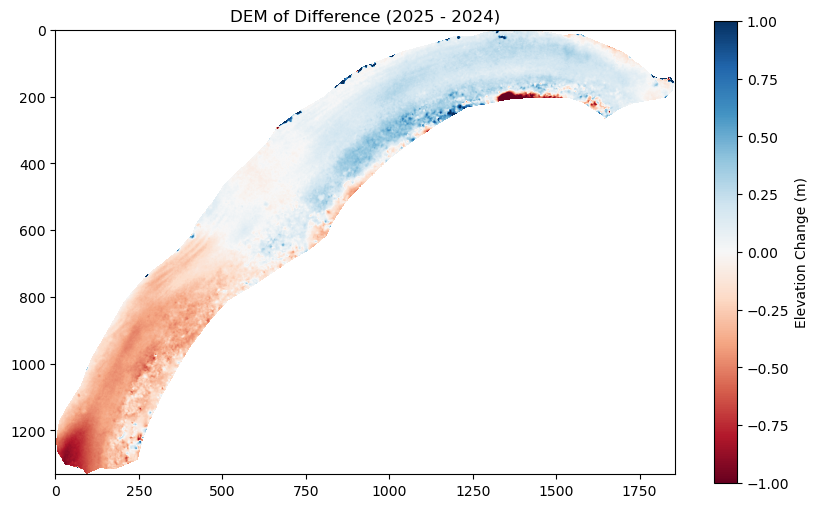

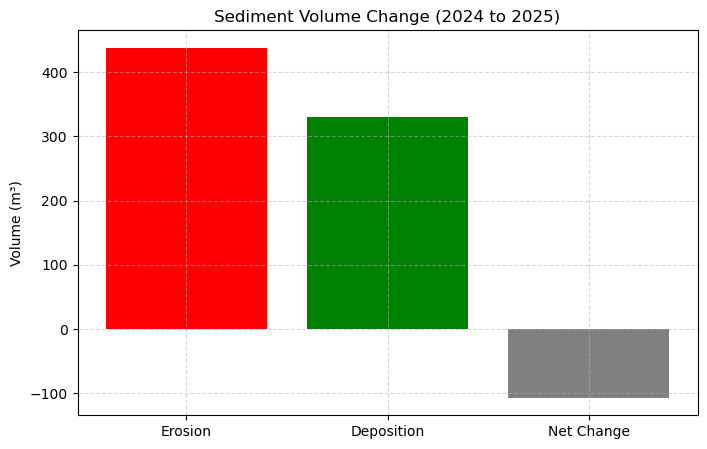

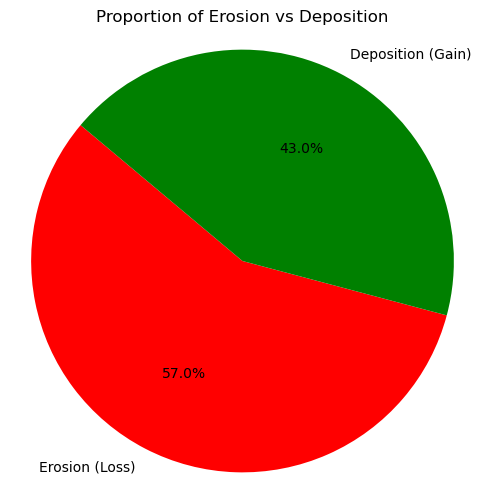

In [3]:
import rasterio
from rasterio.warp import reproject, Resampling
import numpy as np
import matplotlib.pyplot as plt
import math

# File paths, change this into your own directory where you save your DEMs data.Note that all the data must be masked with the same extention
dem_2024_path = r"F:\GIS THESIS\DoD Embayed\Raster\Beach_Clip\Sarangan2024.tif"
dem_2025_path = r"F:\GIS THESIS\DoD Embayed\Raster\Beach_Clip\Sarangan2025.tif"
# Load 2024 DEM
with rasterio.open(dem_2024_path) as src_2024:
    dem_2024 = src_2024.read(1)
    profile_2024 = src_2024.profile
    transform_2024 = src_2024.transform
    crs_2024 = src_2024.crs

# Load and resample 2025 DEM to match 2024
with rasterio.open(dem_2025_path) as src_2025:
    dem_2025_resampled = np.empty_like(dem_2024)
    reproject(
        source=src_2025.read(1),
        destination=dem_2025_resampled,
        src_transform=src_2025.transform,
        src_crs=src_2025.crs,
        dst_transform=transform_2024,
        dst_crs=crs_2024,
        resampling=Resampling.bilinear
    )

# Handle nodata and create mask
nodata = profile_2024.get('nodata', None)
if nodata is not None:
    base_mask = (dem_2024 != nodata) & (dem_2025_resampled != nodata)
else:
    base_mask = ~np.isnan(dem_2024) & ~np.isnan(dem_2025_resampled)

# Calculate DoD
dod = np.where(base_mask, dem_2025_resampled - dem_2024, np.nan)
print("DoD min/max before cleaning:", np.nanmin(dod), np.nanmax(dod))

# Clean invalid extreme values (e.g., -1e+38 artifacts)
valid_range_mask = (dod > -100) & (dod < 100)
dod_cleaned = np.where(base_mask & valid_range_mask, dod, np.nan)

# Compute pixel area
pixel_area = abs(transform_2024[0]) * abs(transform_2024[4])

# Calculate volumes
erosion_vol = np.nansum(np.where(dod_cleaned < 0, dod_cleaned, 0)) * pixel_area
deposition_vol = np.nansum(np.where(dod_cleaned > 0, dod_cleaned, 0)) * pixel_area
net_vol = deposition_vol + erosion_vol

# Output volumes
print(f"\n📉 Erosion Volume (m³): {erosion_vol:.2f}")
print(f"📈 Deposition Volume (m³): {deposition_vol:.2f}")
print(f"🔁 Net Volume Change (m³): {net_vol:.2f}")

# Visualize DoD
plt.figure(figsize=(10, 6))
plt.imshow(dod_cleaned, cmap='RdBu', vmin=-1, vmax=1)
plt.colorbar(label='Elevation Change (m)')
plt.title("DEM of Difference (2025 - 2024)")
plt.show()

# Volume Bar Chart
plt.figure(figsize=(8, 5))
plt.bar(['Erosion', 'Deposition', 'Net Change'],
        [abs(erosion_vol), deposition_vol, net_vol],
        color=['red', 'green', 'gray'])
plt.ylabel("Volume (m³)")
plt.title("Sediment Volume Change (2024 to 2025)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Safe Pie Chart
if all(math.isfinite(v) and v > 0 for v in [abs(erosion_vol), deposition_vol]):
    plt.figure(figsize=(6, 6))
    plt.pie([abs(erosion_vol), deposition_vol],
            labels=['Erosion (Loss)', 'Deposition (Gain)'],
            colors=['red', 'green'],
            autopct='%1.1f%%',
            startangle=140)
    plt.title("Proportion of Erosion vs Deposition")
    plt.axis('equal')
    plt.show()
else:
    print("⚠️ Pie chart skipped: One or both volume values are zero or invalid.")



📦 Total Sediment Volume (2024): 99225.11 m³
📦 Total Sediment Volume (2025): -56215.79 m³


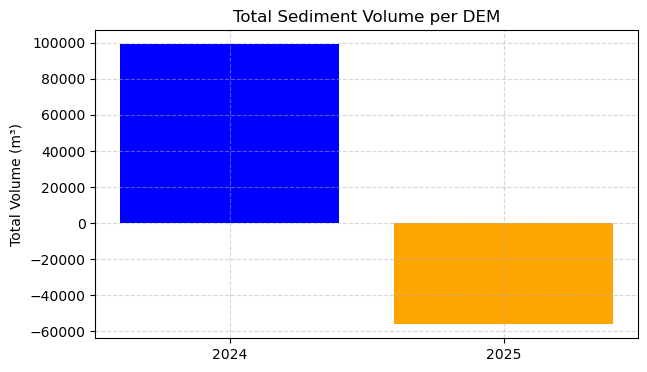

In [2]:
# --- 🌊 Total Volume in Each DEM ---

# Mask valid areas in both DEMs
valid_2024 = base_mask
valid_2025 = base_mask  # already aligned

# Volume in 2024
volume_2024 = np.nansum(np.where(valid_2024, dem_2024, np.nan)) * pixel_area

# Volume in 2025
volume_2025 = np.nansum(np.where(valid_2025, dem_2025_resampled, np.nan)) * pixel_area

# Print volumes
print(f"\n📦 Total Sediment Volume (2024): {volume_2024:.2f} m³")
print(f"📦 Total Sediment Volume (2025): {volume_2025:.2f} m³")

# --- 📊 Bar chart of total volumes ---
plt.figure(figsize=(7, 4))
plt.bar(['2024', '2025'], [volume_2024, volume_2025], color=['blue', 'orange'])
plt.ylabel("Total Volume (m³)")
plt.title("Total Sediment Volume per DEM")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()